# Assignment 2

Before starting: this assignment was followed the older version, and I was only able to realize there is an updated version not long before due. So the structure and content may be a little different. Sorry about that.

In [320]:
# import libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    !pip install seaborn
%matplotlib inline
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix

# import machine learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
try:
    from sklearn.model_selection import GridSearchCV
except:
    from sklearn.grid_search import GridSearchCV
try:
    from sklearn.model_selection import learning_curve
except:
    from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import time

## 1. Data Cleaning

In [105]:
training_df=pd.read_csv('income-training.csv')
testing_df=pd.read_csv('income-testing.csv')

In [110]:
# find if there which attribute has missing data
print(training_df.info())
print(testing_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 14 columns):
Age              24421 non-null int64
WorkClass        23037 non-null object
FinalWeight      24421 non-null int64
EducationLvl     24421 non-null int64
MaritalStatus    24421 non-null object
Occupation       23031 non-null object
Relationship     24421 non-null object
Race             24421 non-null object
Sex              24421 non-null object
CapitalGain      24421 non-null int64
CapitalLoss      24421 non-null int64
HoursPerWeek     24421 non-null int64
NativeCountry    24026 non-null object
IncomeBracket    24421 non-null object
dtypes: int64(6), object(8)
memory usage: 2.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12211 entries, 0 to 12210
Data columns (total 14 columns):
Age              12211 non-null int64
WorkClass        11523 non-null object
FinalWeight      12211 non-null int64
EducationLvl     12211 non-null int64
MaritalStatus    12211 non-null ob

In [129]:
print(training_df['Age'].unique())
print(training_df['WorkClass'].unique())
print(training_df['FinalWeight'].unique())
print(training_df['EducationLvl'].unique())
print(training_df['MaritalStatus'].unique())
print(training_df['Occupation'].unique())
print(training_df['Relationship'].unique())
print(training_df['Race'].unique())
print(training_df['Sex'].unique())
print(training_df['CapitalGain'].unique())
print(training_df['CapitalLoss'].unique())
print(training_df['HoursPerWeek'].unique())
print(training_df['NativeCountry'].unique())
print(training_df['IncomeBracket'].unique())

[42 28 24 32 55 35 51 43 29 65 20 45 52 25 40 30 44 39 19 41 33 18 22 54 21
 31 49 36 37 17 57 67 46 34 59 53 66 74 47 27 58 48 63 61 23 26 56 50 38 71
 64 79 76 62 72 90 60 69 70 77 78 85 68 75 81 80 73 88 87 82 83 89 84]
['State-gov' 'Private' 'Self-emp-not-inc' 'Self-emp-inc' nan 'Federal-gov'
 'Local-gov' 'Never-worked' 'Without-pay']
[179151  68021 233499 ..., 190661 113751 294642]
[10  5 14  9 13 11 12  7  6 15 16  2  3  8  4  1]
['Married-civ-spouse' 'Never-married' 'Divorced' 'Widowed' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
['Farming-fishing' 'Other-service' 'Transport-moving' 'Craft-repair'
 'Sales' 'Adm-clerical' 'Exec-managerial' 'Tech-support' nan
 'Machine-op-inspct' 'Handlers-cleaners' 'Protective-serv' 'Prof-specialty'
 'Priv-house-serv' 'Armed-Forces']
['Husband' 'Not-in-family' 'Unmarried' 'Own-child' 'Wife' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
['Male' 'Female']
[    0  2228  4787  3908  3137 15024  68

From the result above, it is seen that 'WorkClass','Occupation' and 'NativeCountry' have missing values 'NaN'. In the meantime, high frequency of '0' in 'CapitalGain' and 'CapitalLoss' are seen as potential data missing, but the decision was not to change given the definition 'capital gain/loss in investment' where 0 means no investment activity of individual. The cause of data loss in this case may be from the survet system without proper options or the interviewee prefered not to share. Consider these attributes are all non-numerical type, the mean and median are not applicable, there for the missing data are filled with the mod of the column.
Considering the options in 'Education' correspond to options in 'EductionLvl'which indicates duplicate function, the 'Education' feature was removed.

In [107]:
training_df= training_df.drop('Education', axis=1)
testing_df= testing_df.drop('Education', axis=1)
testing_df.head()

,Age,WorkClass,FinalWeight,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,Self-emp-not-inc,152030,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,25,United-States,50-100K
1,35,Private,341643,13,Never-married,Other-service,Other-relative,White,Male,0,0,50,United-States,<50K
2,26,Private,40915,13,Never-married,Other-service,Not-in-family,White,Female,0,0,25,United-States,<50K
3,27,Federal-gov,257124,13,Never-married,Transport-moving,Other-relative,White,Male,0,0,35,United-States,<50K
4,21,Private,256278,9,Never-married,Other-service,Other-relative,Other,Female,0,0,35,El-Salvador,<50K


In [108]:
def clean(raw):
    #find the mode of the column and substitute with NaN
    a=unfilled['WorkClass'].mode()
    b=unfilled['Occupation'].mode()
    c=unfilled['NativeCountry'].mode()
    filled1=raw.replace({'WorkClass': np.nan}, {'WorkClass': a[0]})
    filled2=filled1.replace({'Occupation': np.nan},{'Occupation': b[0]})
    filled3=filled2.replace({'NativeCountry': np.nan}, {'NativeCountry': c[0]})
    
    #Convert categorical data into numerical data
    #WorkClass transformation
    raw1=filled3.replace({'WorkClass': 'State-gov'}, {'WorkClass': 0})
    raw2=raw1.replace({'WorkClass': 'Private'}, {'WorkClass': 1})
    raw3=raw2.replace({'WorkClass': 'Self-emp-not-inc'}, {'WorkClass': 2})
    raw4=raw3.replace({'WorkClass': 'Self-emp-inc'}, {'WorkClass': 3})
    raw5=raw4.replace({'WorkClass': 'Federal-gov'}, {'WorkClass': 4})
    raw6=raw5.replace({'WorkClass': 'Local-gov'}, {'WorkClass': 5})
    raw7=raw6.replace({'WorkClass': 'Never-worked'}, {'WorkClass': 6})
    raw8=raw7.replace({'WorkClass': 'Without-pay'}, {'WorkClass': 7})
    #Education transformation: attribute removed
    #MaritalStatus Transformation
    raw9=raw8.replace({'MaritalStatus': 'Married-civ-spouse'}, {'MaritalStatus': 0})
    raw10=raw9.replace({'MaritalStatus': 'Never-married'}, {'MaritalStatus': 1})
    raw11=raw10.replace({'MaritalStatus': 'Divorced'}, {'MaritalStatus': 2})
    raw12=raw11.replace({'MaritalStatus': 'Widowed'}, {'MaritalStatus': 3})
    raw13=raw12.replace({'MaritalStatus': 'Separated'}, {'MaritalStatus': 4})
    raw14=raw13.replace({'MaritalStatus': 'Married-spouse-absent'}, {'MaritalStatus': 5})
    raw15=raw14.replace({'MaritalStatus': 'Married-AF-spouse'}, {'MaritalStatus': 6})
    #MaritalStatus Transformation
    raw16=raw15.replace({'Occupation': 'Farming-fishing'}, {'Occupation': 0})
    raw17=raw16.replace({'Occupation': 'Other-service'}, {'Occupation': 1})
    raw18=raw17.replace({'Occupation': 'Transport-moving'}, {'Occupation': 2})
    raw19=raw18.replace({'Occupation': 'Craft-repair'}, {'Occupation': 3})
    raw20=raw19.replace({'Occupation': 'Sales'}, {'Occupation': 4})
    raw21=raw20.replace({'Occupation': 'Adm-clerical'}, {'Occupation': 5})
    raw22=raw21.replace({'Occupation': 'Exec-managerial'}, {'Occupation': 6})
    raw23=raw22.replace({'Occupation': 'Tech-support'}, {'Occupation': 7})
    raw24=raw23.replace({'Occupation': 'Machine-op-inspct'}, {'Occupation': 8})
    raw25=raw24.replace({'Occupation': 'Handlers-cleaners'}, {'Occupation': 9})
    raw26=raw25.replace({'Occupation': 'Protective-serv'}, {'Occupation': 10})
    raw27=raw26.replace({'Occupation': 'Prof-specialty'}, {'Occupation': 11})
    raw28=raw27.replace({'Occupation': 'Priv-house-serv'}, {'Occupation': 12})
    raw29=raw28.replace({'Occupation': 'Armed-Forces'}, {'Occupation': 13})
    #Relationship Transformation
    raw30=raw29.replace({'Relationship': 'Husband'}, {'Relationship': 0})
    raw31=raw30.replace({'Relationship': 'Not-in-family'}, {'Relationship': 1})
    raw32=raw31.replace({'Relationship': 'Unmarried'}, {'Relationship': 2})
    raw33=raw32.replace({'Relationship': 'Own-child'}, {'Relationship': 3})
    raw34=raw33.replace({'Relationship': 'Wife'}, {'Relationship': 4})
    raw35=raw34.replace({'Relationship': 'Other-relative'}, {'Relationship': 5})
    #Race Transformation
    raw36=raw35.replace({'Race': 'White'}, {'Race': 0})
    raw37=raw36.replace({'Race': 'Black'}, {'Race': 1})
    raw38=raw37.replace({'Race': 'Asian-Pac-Islander'}, {'Race': 2})
    raw39=raw38.replace({'Race': 'Other'}, {'Race': 3})
    raw40=raw39.replace({'Race': 'Amer-Indian-Eskimo'}, {'Race': 4})
    #Sex Transformation + #NativeCountry Transformation +#IncomeBracket
    cleanup_nums = {'Sex':{"Female": 0, "Male": 1},/
                    'NativeCountry': {'United-States':0,'Outlying-US(Guam-USVI-etc)':1,'Mexico':2,'El-Salvador':3, 'Taiwan':4, 'Haiti':5, 'Cuba':6, 'Philippines':7, 'Puerto-Rico':8, 'Japan':9, 'Thailand':10,'Hungary':11, 'France':12, 'Columbia':13, 'India':14, 'Jamaica':15, 'Germany':16, 'Peru':17, 'Canada':18,'Hong':19, 'Italy':20, 'Honduras':21, 'Poland':22, 'Ecuador':23, 'Ireland':24, 'Cambodia':25,'Guatemala':26, 'Dominican-Republic':27, 'Greece':28, 'Nicaragua':29, 'Iran':30, 'Vietnam':31,'Trinadad&Tobago':32, 'China':33, 'South':34, 'England':35, 'Yugoslavia':36, 'Portugal':37, 'Laos':38,'Scotland':39, 'Holand-Netherlands':40 },'IncomeBracket':{'<50K': 0, '50-100K': 1,'>100K':2}}
    raw40.replace(cleanup_nums, inplace=True)
    
    return raw40
  
training_cleaned=clean(training_df)
testing_cleaned=clean(testing_df)

The function above is able to fill the missing data and convert dataframe to numerical by encoding. The reason for the conversion is because most of the machine learning methods only accept numerical inputs.
After the transformation, the numerical meaning of each option in each fattribute can be rooted from code above. The objective 'IncomeBracket' here emphasized: '<50K' is 0, '50-100K' is 1, '>100K' is 2.

## 2. Exploratory Data Analysis

### a)

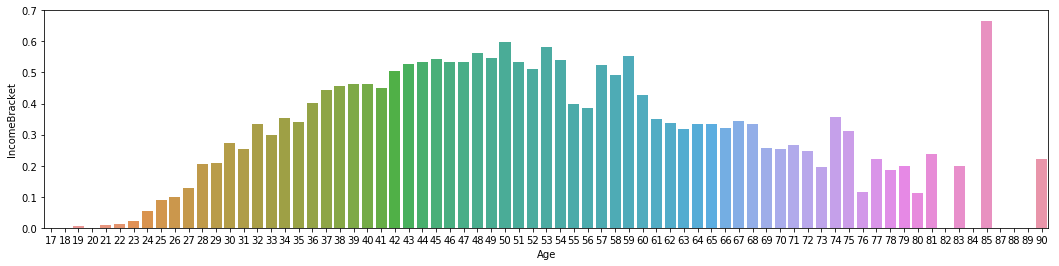

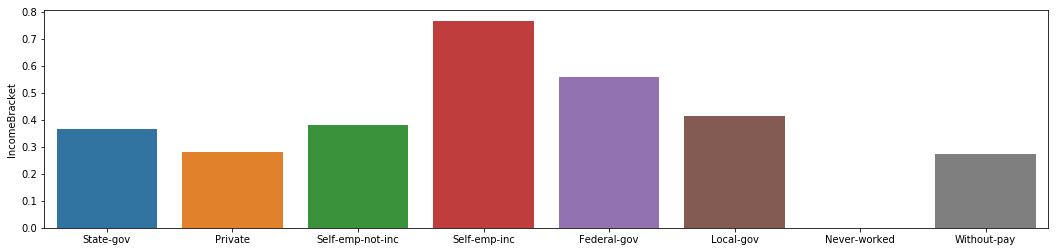

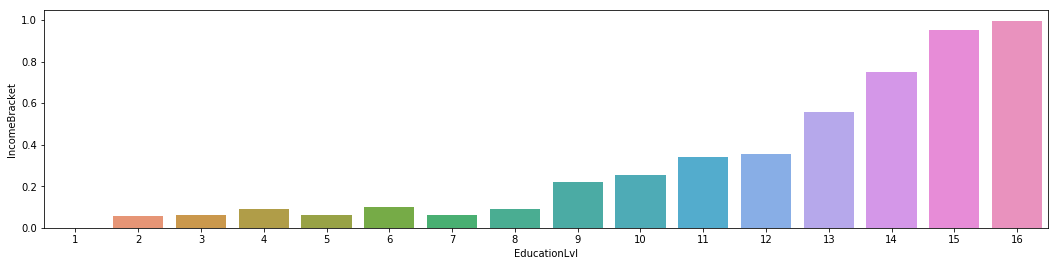

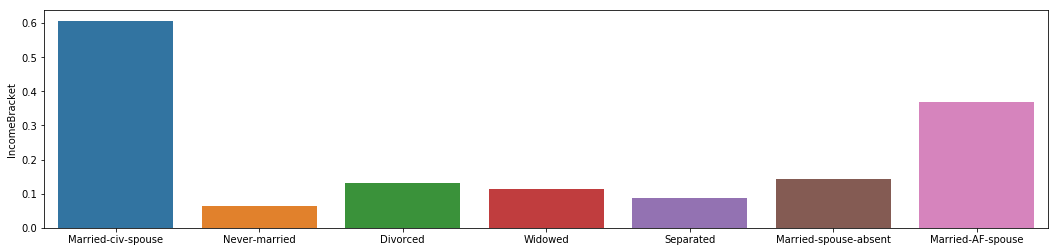

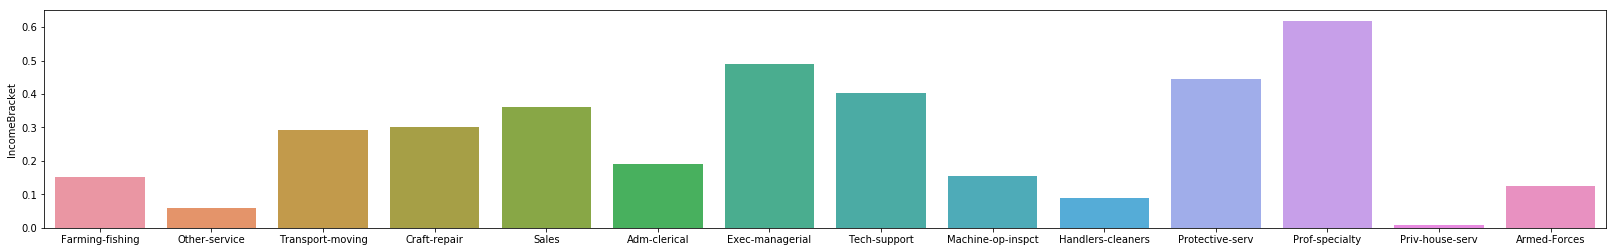

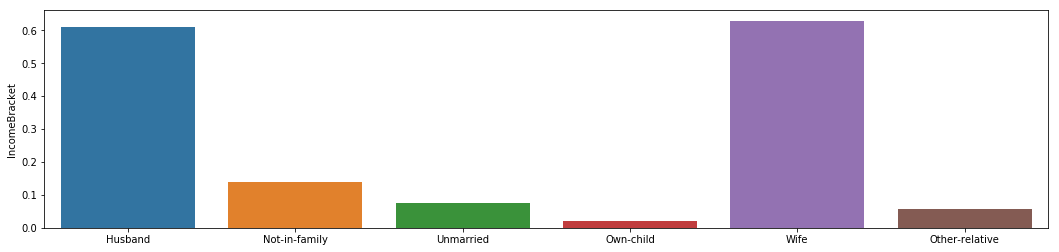

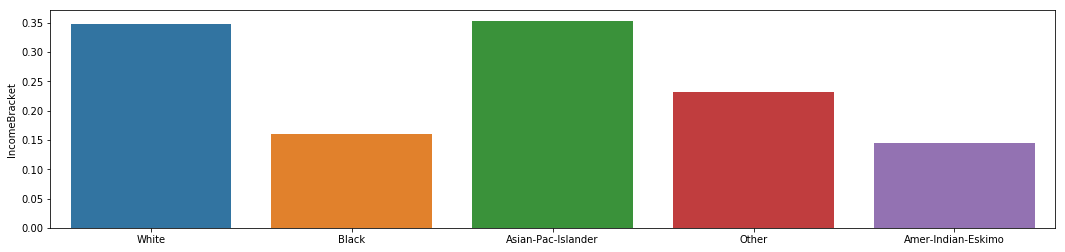

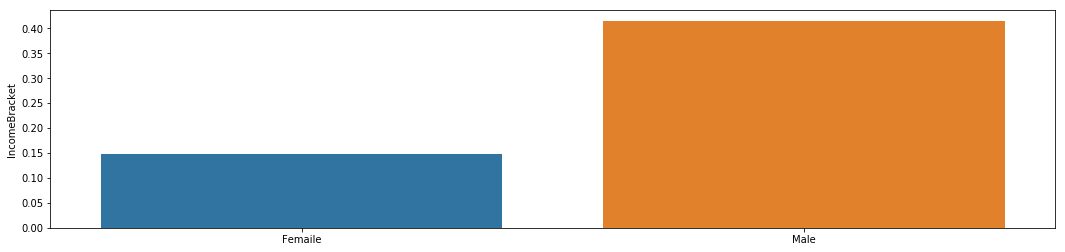

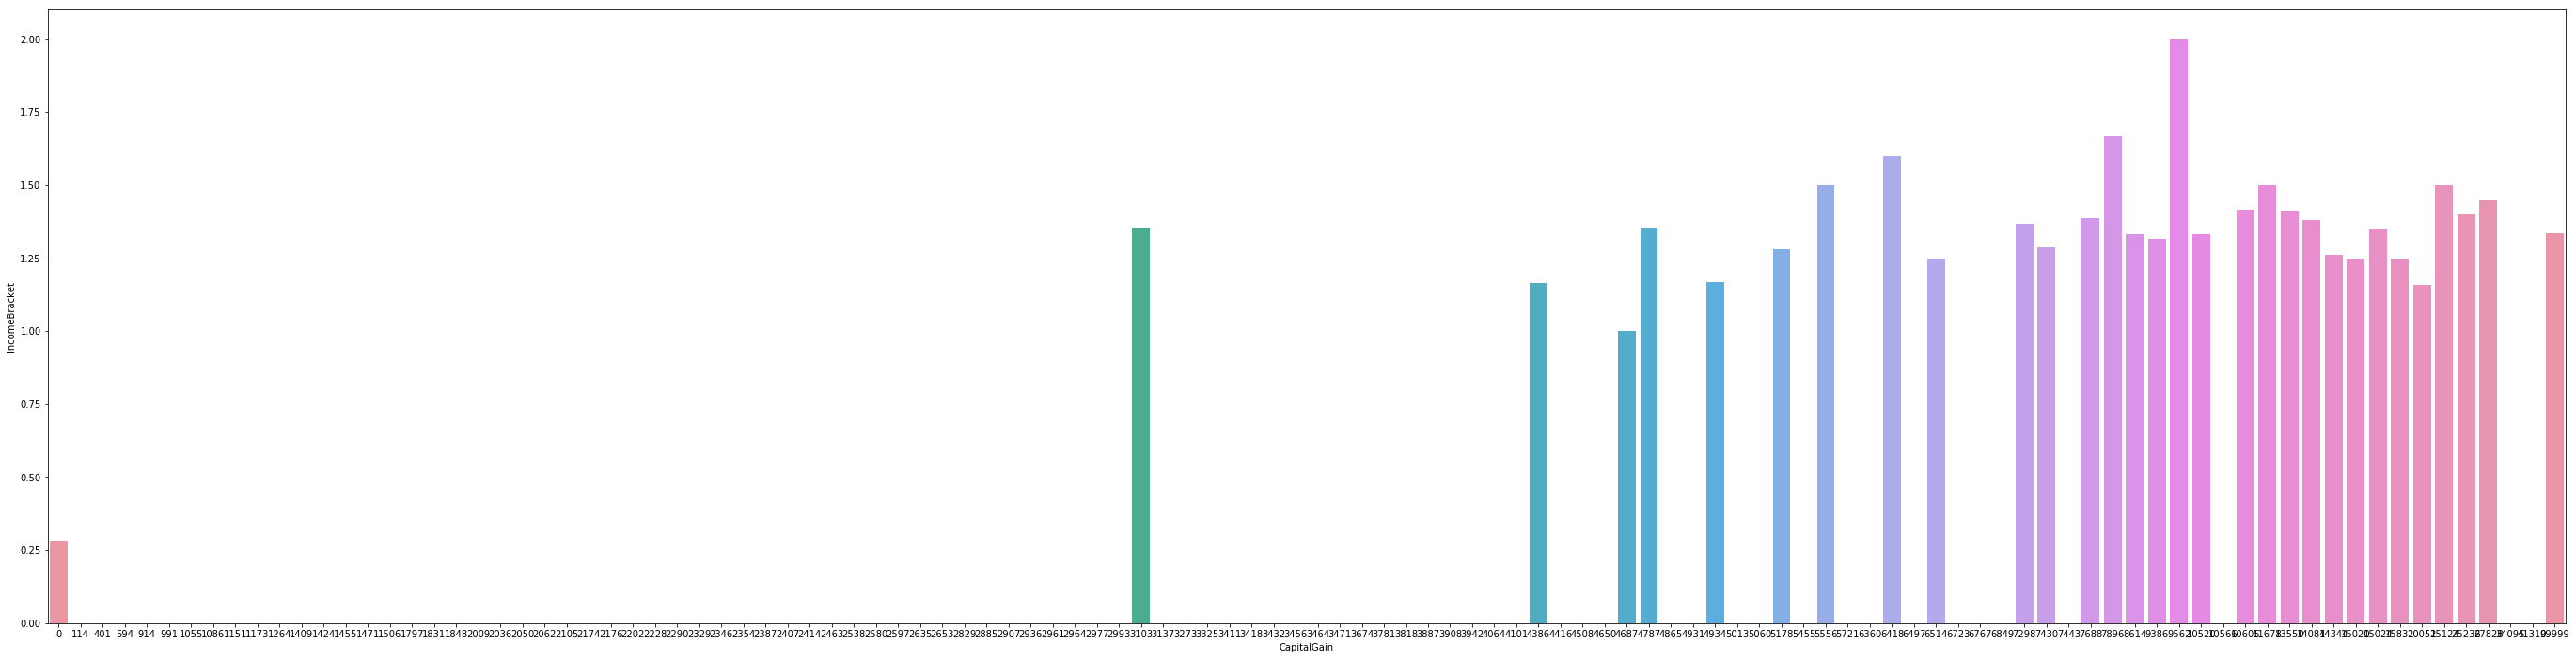

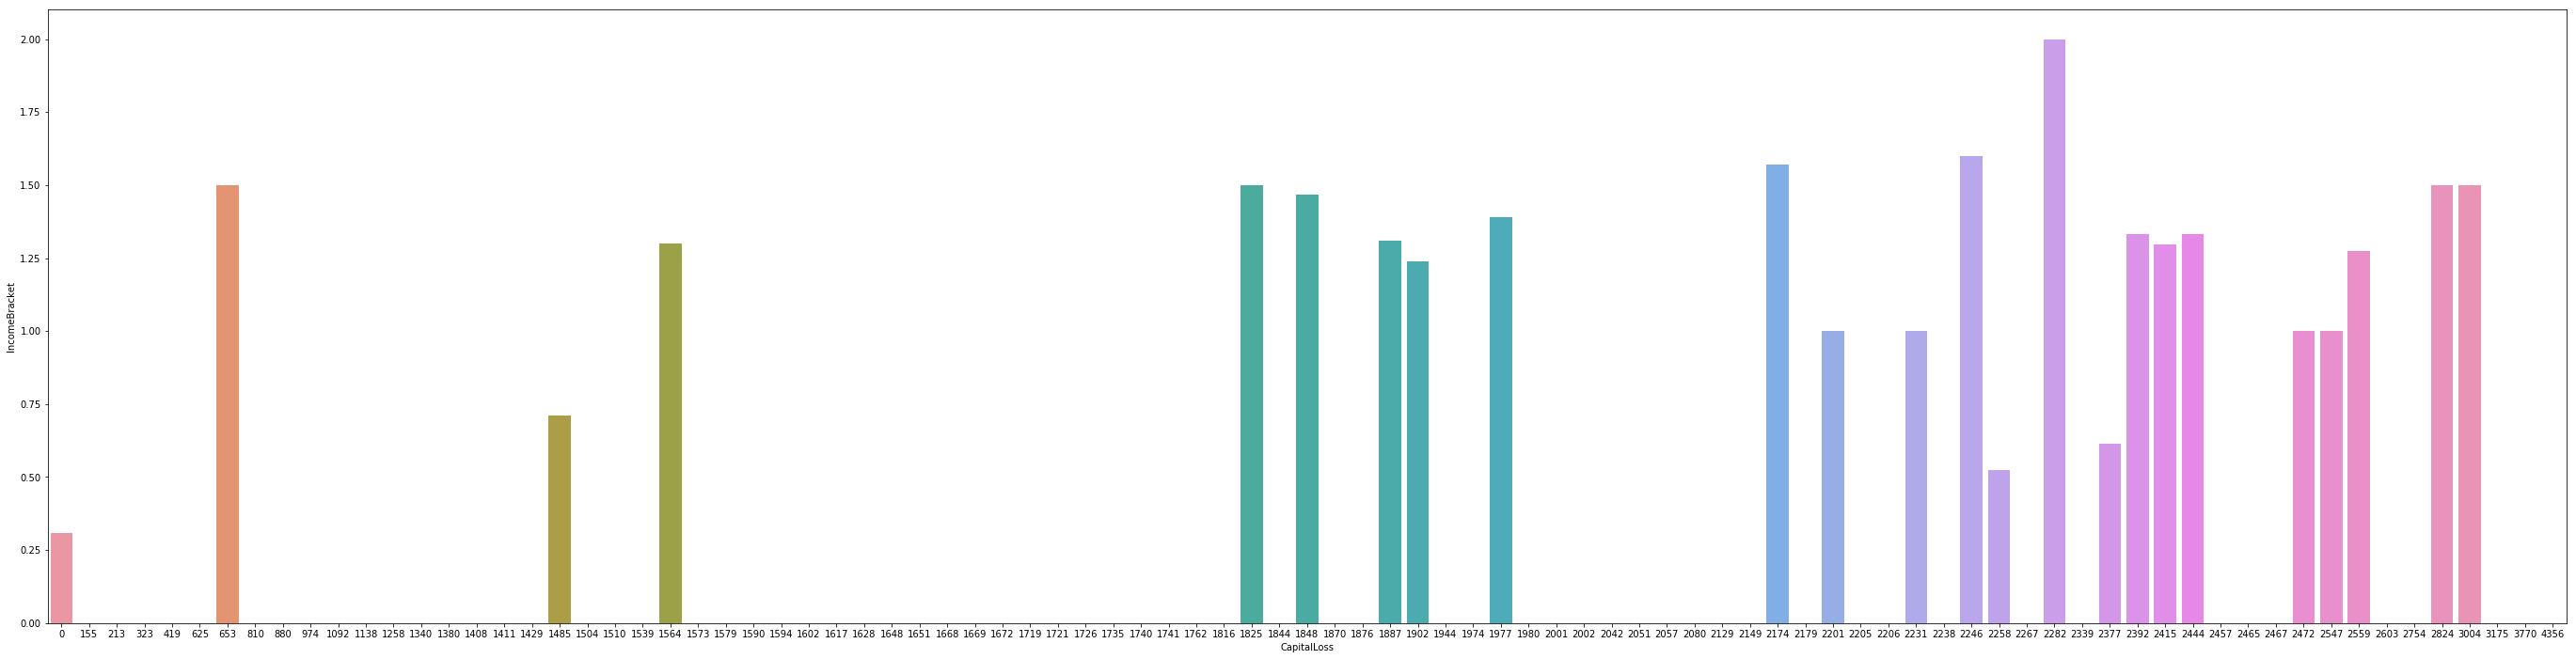

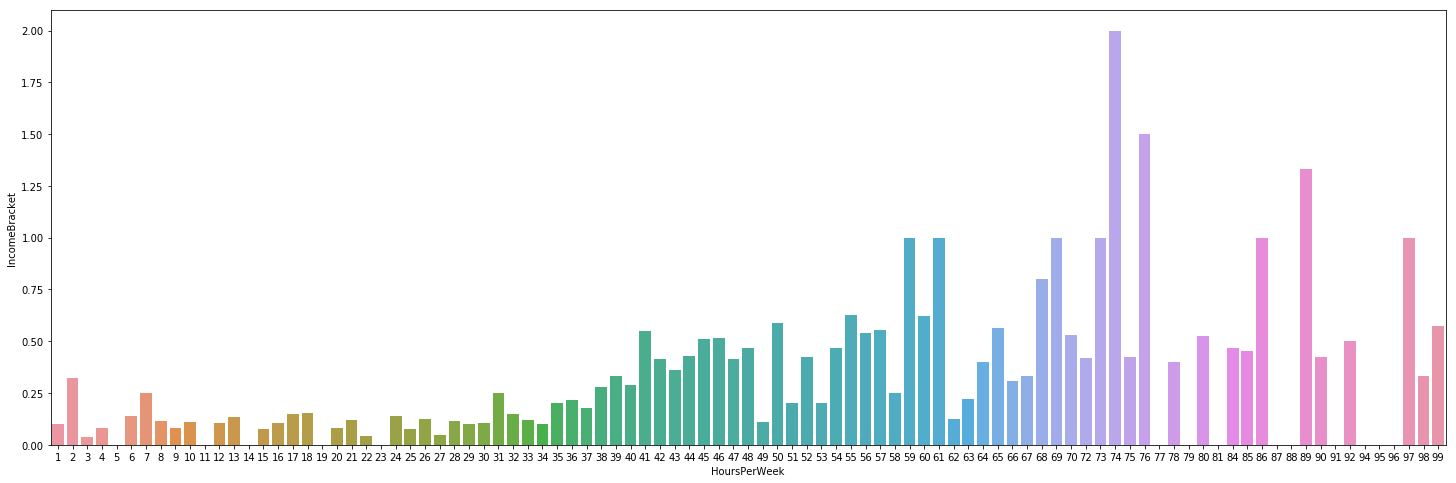

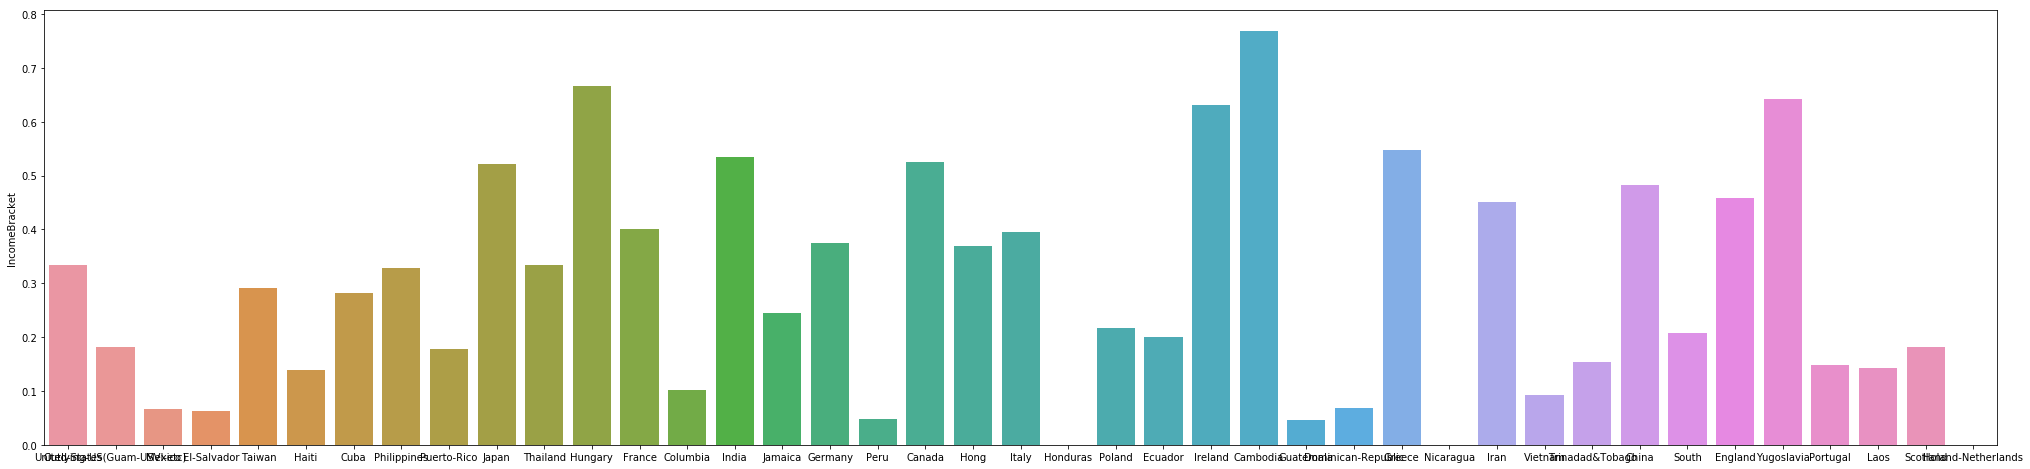

In [339]:
# group by feature, and get the mean for IncomeBraacket for each ooption in that feature

# Age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = training_cleaned[["Age", "IncomeBracket"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='IncomeBracket', data=average_age)

#WorkClass
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_WorkClass = training_cleaned[["WorkClass", "IncomeBracket"]].groupby(['WorkClass'],as_index=False).mean()
sns.barplot(x=['State-gov','Private','Self-emp-not-inc','Self-emp-inc','Federal-gov','Local-gov','Never-worked','Without-pay'], y='IncomeBracket', data=average_WorkClass)

#FinalWeight
"""
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_FinalWeight = training_cleaned[["FinalWeight", "IncomeBracket"]].groupby(['FinalWeight'],as_index=False).mean()
sns.barplot(x='FinalWeight', y='IncomeBracket', data=average_FinalWeight)
"""
#This part is commented out as there are too many values under FinalWeight and unable to appropriately indicate the relation.

#EducationLvl
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_EducationLvl = training_cleaned[["EducationLvl", "IncomeBracket"]].groupby(['EducationLvl'],as_index=False).mean()
sns.barplot(x='EducationLvl', y='IncomeBracket', data=average_EducationLvl)

#MaritalStatus
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_MaritalStatus = training_cleaned[["MaritalStatus", "IncomeBracket"]].groupby(['MaritalStatus'],as_index=False).mean()
sns.barplot(x=['Married-civ-spouse','Never-married','Divorced','Widowed','Separated','Married-spouse-absent','Married-AF-spouse'], y='IncomeBracket', data=average_MaritalStatus)

#Occupation
fig, axis1 = plt.subplots(1,1,figsize=(28,4))
average_Occupation = training_cleaned[["Occupation", "IncomeBracket"]].groupby(['Occupation'],as_index=False).mean()
sns.barplot(x=['Farming-fishing','Other-service','Transport-moving','Craft-repair','Sales','Adm-clerical','Exec-managerial','Tech-support','Machine-op-inspct','Handlers-cleaners','Protective-serv','Prof-specialty','Priv-house-serv','Armed-Forces'], y='IncomeBracket', data=average_Occupation)

#Relationship
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_Relationship = training_cleaned[["Relationship", "IncomeBracket"]].groupby(['Relationship'],as_index=False).mean()
sns.barplot(x=['Husband','Not-in-family','Unmarried','Own-child','Wife','Other-relative'], y='IncomeBracket', data=average_Relationship)

#Race
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_Race = training_cleaned[["Race", "IncomeBracket"]].groupby(['Race'],as_index=False).mean()
sns.barplot(x=['White','Black','Asian-Pac-Islander','Other','Amer-Indian-Eskimo'], y='IncomeBracket', data=average_Race)

#Sex
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_Sex = training_cleaned[["Sex", "IncomeBracket"]].groupby(['Sex'],as_index=False).mean()
sns.barplot(x=['Femaile','Male'], y='IncomeBracket', data=average_Sex)

#CapitalGain
fig, axis1 = plt.subplots(1,1,figsize=(48,12))
average_CapitalGain = training_cleaned[["CapitalGain", "IncomeBracket"]].groupby(['CapitalGain'],as_index=False).mean()
sns.barplot(x='CapitalGain', y='IncomeBracket', data=average_CapitalGain)

#CapitalLoss
fig, axis1 = plt.subplots(1,1,figsize=(48,12))
average_CapitalLoss = training_cleaned[["CapitalLoss", "IncomeBracket"]].groupby(['CapitalLoss'],as_index=False).mean()
sns.barplot(x='CapitalLoss', y='IncomeBracket', data=average_CapitalLoss)

#HoursPerWeek
fig, axis1 = plt.subplots(1,1,figsize=(25,8))
average_HoursPerWeek = training_cleaned[["HoursPerWeek", "IncomeBracket"]].groupby(['HoursPerWeek'],as_index=False).mean()
sns.barplot(x='HoursPerWeek', y='IncomeBracket', data=average_HoursPerWeek)

#NativeCountry
fig, axis1 = plt.subplots(1,1,figsize=(35,8))
average_NativeCountry = training_cleaned[["NativeCountry", "IncomeBracket"]].groupby(['NativeCountry'],as_index=False).mean()
sns.barplot(x=['United-States','Outlying-US(Guam-USVI-etc)','Mexico','El-Salvador','Taiwan','Haiti','Cuba','Philippines','Puerto-Rico','Japan','Thailand','Hungary','France','Columbia','India','Jamaica','Germany','Peru','Canada','Hong','Italy','Honduras','Poland','Ecuador','Ireland','Cambodia','Guatemala','Dominican-Republic','Greece','Nicaragua','Iran','Vietnam','Trinadad&Tobago','China','South','England','Yugoslavia','Portugal','Laos','Scotland','Holand-Netherlands'], y='IncomeBracket', data=average_NativeCountry)

The graph above calculated the IncomeBracket mean of each options for each feature. This can show if the options of one feature is related to IncomeVariance. For continuous features like Age and EducationLvl, it can show a clear trend and indicate the potential algebratic relation; on contrast, CapitalGain and CapitalLoss seems irrelevant to IncomeBracket.
The FinalWeight feature is not proceeded directly as too many values included. It will first categozie and renumerized then plot the graph. As continuous category, it is best to splite in range. Find the range of 'FinalWeight' as below, 

### b) 

Here the feature importance is discovered by correlation plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000235B08808D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000235B7B63F60>]], dtype=object)

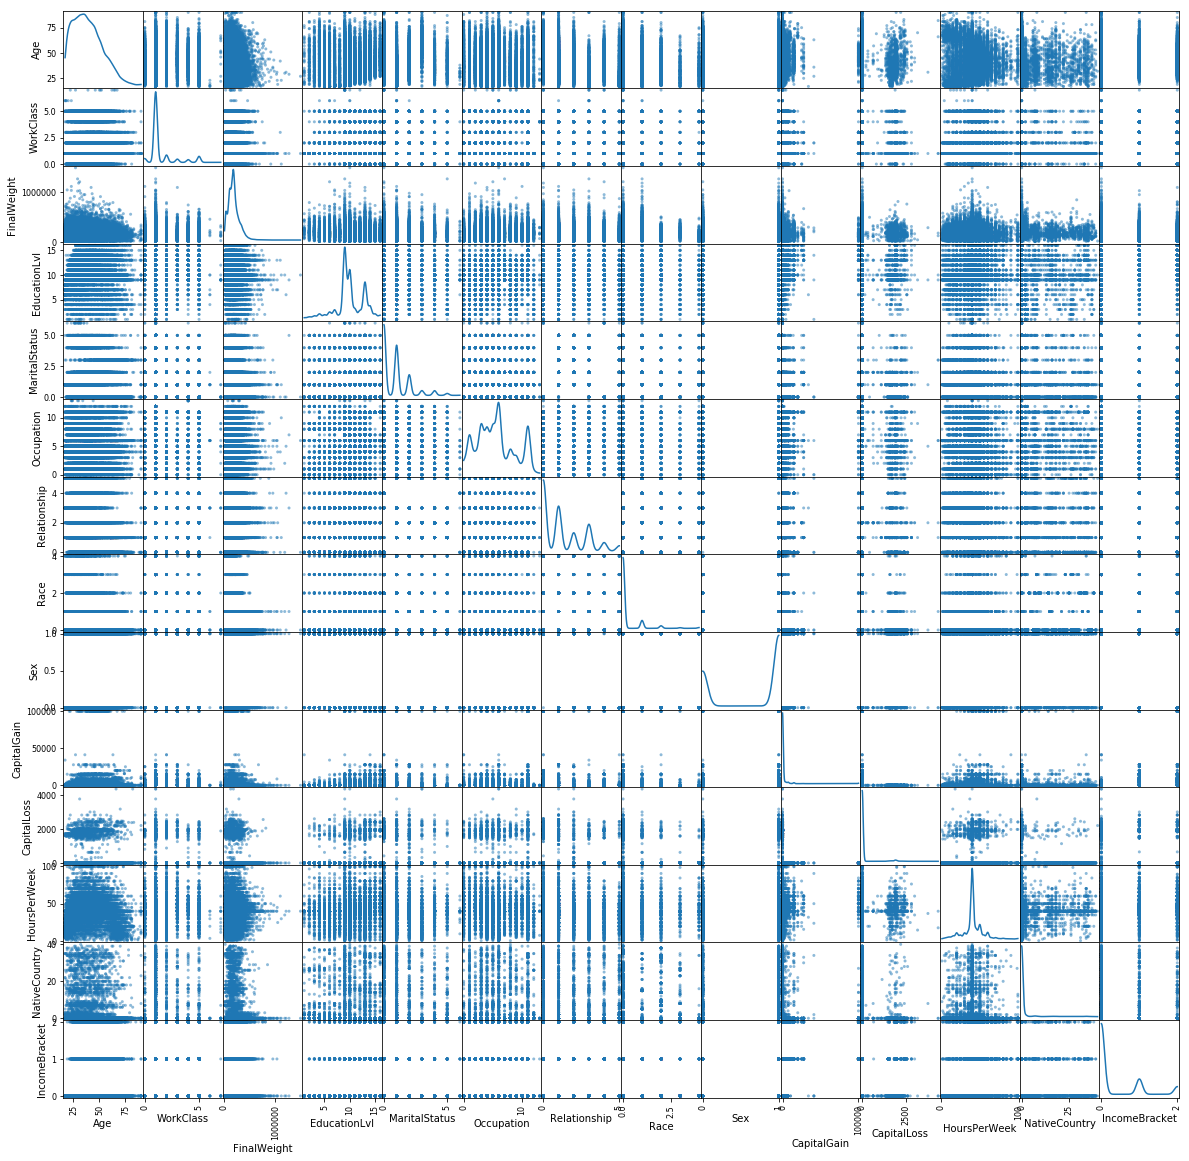

In [195]:
scatter_matrix(training_cleaned.ix[:,0:14],   # Make a scatter matrix of 6 columns
               figsize=(20, 20),   # Set plot size
               diagonal='kde')    # Show distribution estimates on diagonal

In [187]:
training_cleaned.ix[:,0:14].corr()

,Age,WorkClass,FinalWeight,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
Age,1.000000,0.136444,-0.085118,0.040821,-0.001540,0.042128,-0.345720,-0.040308,0.084536,0.075229,0.059132,0.069133,0.015562,0.215345
WorkClass,0.136444,1.000000,-0.022015,0.119145,-0.037617,0.112671,-0.069956,0.015994,0.024688,0.033948,0.027076,0.073968,-0.021155,0.104664
FinalWeight,-0.085118,-0.022015,1.000000,-0.040947,0.008418,0.009354,0.021936,-0.007854,0.034786,-0.005131,0.002625,-0.015199,0.008916,-0.008547
EducationLvl,0.040821,0.119145,-0.040947,1.000000,-0.104201,0.344377,-0.124431,-0.031363,0.014817,0.131804,0.079319,0.144161,-0.016584,0.312047
MaritalStatus,-0.001540,-0.037617,0.008418,-0.104201,1.000000,-0.035825,0.334434,0.071785,-0.389071,-0.047181,-0.052824,-0.127158,0.013893,-0.294774
Occupation,0.042128,0.112671,0.009354,0.344377,-0.035825,1.000000,-0.038103,-0.000290,-0.026024,0.070135,0.040382,0.036839,0.020629,0.165570
Relationship,-0.345720,-0.069956,0.021936,-0.124431,0.334434,-0.038103,1.000000,0.094255,-0.497474,-0.061211,-0.058644,-0.276496,0.024996,-0.258173
Race,-0.040308,0.015994,-0.007854,-0.031363,0.071785,-0.000290,0.094255,1.000000,-0.067333,-0.005573,-0.015606,-0.030988,0.219717,-0.060137
Sex,0.084536,0.024688,0.034786,0.014817,-0.389071,-0.026024,-0.497474,-0.067333,1.000000,0.045600,0.052090,0.225756,-0.005702,0.203177
CapitalGain,0.075229,0.033948,-0.005131,0.131804,-0.047181,0.070135,-0.061211,-0.005573,0.045600,1.000000,-0.032197,0.089706,0.000296,0.206740


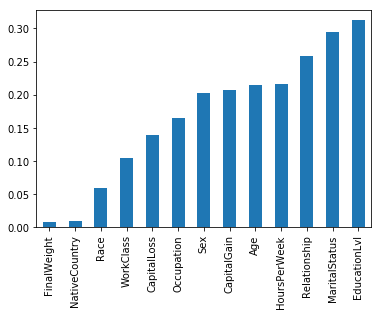

In [212]:
# draw the bar chart of the feature absolute correlation coefficient to IncomeBracket
training_correlation = training_cleaned.iloc[:,0:14].corr()
training_correlation.iloc[-1,0:13].abs().sort_values().plot(kind='bar')

The above graph has absolute the coefficient and sort the values. Therefore, higher coefficient value indicates higher importance, and the feature importance from high to low is: EducationLvl, MaritalStatus, Relationship, HoursPerWeek, Age, CapitalGain, Sex, Occupation, CapitalLoss, WorkClass, Race, NativeCountry and FinalWeight.

## 3.Feature Selection

To create a new feature, here consider the 6th important feature Capital. Basic on the terminology explanation, both features express the result of investment, therefore, they can be combined as gain for positive and loss for negative. In addition, the 'Education' feature removed from first part is also a feature engineering method to avoid duplicate features.
The feature engineering is a important part for machine learning as it will create new useful feature, modify the inaccurate feature or remove problematic/irrelevant/duplicate features. These will increase the efficiency of machine learning.

In [222]:
# create a new feature 'NetCapital' in training_cleaned
training_cleaned['NetCapital']=training_cleaned['CapitalGain']-training_cleaned['CapitalLoss']
testing_cleaned['NetCapital']=testing_cleaned['CapitalGain']-testing_cleaned['CapitalLoss']
training_cleaned.head()

,Age,WorkClass,FinalWeight,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,NetCapital
0,42,0,179151,10,0,0,0,0,1,0,0,40,0,0,0
1,28,1,68021,10,1,1,1,0,0,0,0,30,0,0,0
2,24,1,233499,10,0,2,0,0,1,0,0,40,0,1,0
3,32,2,168782,5,0,3,0,0,1,0,0,32,0,0,0
4,55,2,105582,14,0,4,0,0,1,2228,0,50,0,0,2228


Given the feature importance, the 'FinalWeight' and 'NativeCountry' has weak correaltion to 'IncomeBracket', therefore should not be considered in the model. 'CapitalGain' and 'CapitalLoss' are represented by 'NetCapital'. Therefore the prepared training data set is as below.

In [223]:
training_data=training_cleaned[['Age','WorkClass','EducationLvl','MaritalStatus','Occupation','Relationship','Race','Sex','NetCapital','HoursPerWeek','IncomeBracket']]
testing_data=testing_cleaned[['Age','WorkClass','EducationLvl','MaritalStatus','Occupation','Relationship','Race','Sex','NetCapital','HoursPerWeek','IncomeBracket']]
testing_data.head()

,Age,WorkClass,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,NetCapital,HoursPerWeek,IncomeBracket
0,57,2,10,0,4,4,0,0,0,25,1
1,35,1,13,1,1,5,0,1,0,50,0
2,26,1,13,1,1,1,0,0,0,25,0
3,27,4,13,1,2,5,0,1,0,35,0
4,21,1,9,1,1,5,3,0,0,35,0


## 4. Model Implementation

In [246]:
# define training data variables
x_train = training_data.drop(['IncomeBracket'], axis=1)
y_train = training_data.IncomeBracket
x_test = testing_data.drop(['IncomeBracket'], axis=1)
y_test = testing_data.IncomeBracket

### a.Random Forest

In [323]:
#Timer
start_time = time.time()

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 'max_features': ['log2', 'sqrt','auto'], 'criterion': ['entropy', 'gini'],'max_depth': [2, 3, 5, 10], 'min_samples_split': [2, 3, 5],'min_samples_leaf': [1,5,8]}

# make_scorer returns a callable object that scores an estimator’s output.
#We are using accuracy_score for comparing different parameter combinations. 
acc_scorer = make_scorer(accuracy_score)

# Run the grid search for the Random Forest classifier
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(x_train, y_train)

# Set our classifier, clf, to the have the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the selected classifier to the training data
clf.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 108.08854746818542 seconds ---


The algorithm used is Random Forest which build decision trees and out put the mode of the classes in classification. The pro is the low bias; the con is high variance and relatively high computation time. In this classification, as there is not many assumptions NaN (bias), this model's low variance is a benefit. 

### b. Logistic Regression

In [322]:
#Timer
start_time = time.time()

# Choose the type of classifier. Select solver'lbfg' and multi_class for multi class model
lg = LogisticRegression(random_state=42, solver='lbfgs',multi_class='ovr',penalty='l2')
parameters = {'C':[0.5]}

# Use classification accuracy to compare parameter combinations
acc_scorer_lg = make_scorer(accuracy_score)

# Run a grid search for the Logistic Regression classifier and all the selected parameters
grid_obj_lg = GridSearchCV(lg, parameters, scoring=acc_scorer_lg)
grid_obj_lg = grid_obj_lg.fit(x_train, y_train)

# Set our classifier, lg, to have the best combination of parameters
lg = grid_obj_lg.best_estimator_

# Fit the selected classifier to the training data. 
lg.fit(x_train, y_train)

# Find predictions and get accuracy
predictions_lg = lg.predict(x_test)
print(accuracy_score(y_test, predictions_lg))

print("--- %s seconds ---" % (time.time() - start_time))

0.770207190238
--- 2.2893154621124268 seconds ---


The logistic regression use numerical inputs to calculate results and categorize the result to a certain class. Pro is easy to train; con is limited to linear model and relatively high computation time. The reason for choosing this model is because this model linearization is a common method to try and highly reliable, and in the meantime it supports multiclass classification.

### c. Decision Tree

In [327]:
#Timer
start_time = time.time()

# Choose the type of classifier.
model = tree.DecisionTreeClassifier(criterion = "entropy")

# Fit the selected classifier to the training data.
model.fit(x_train, y_train)

# Find predictions and get accuracy
predictions_model = model.predict(x_test)
accuracy_score(y_test, predictions_model)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0914764404296875 seconds ---


Decision tree is flow-chart and trr-shape like structure, where each branch represensts a test outcome. The pro is capable of dealing multiple types of feature, less proceeding time and ablility to cope with continuous and discrete data; con is high error rate for small training set, calculation grow exponentially as feature goes more. The reason for choosing this is the short proceeding time, relatively less features and it is a common way to solve classification problem.

### d. K-nearest Neighbor

In [330]:
#Timer
start_time = time.time()

# Choose the type of classifier.
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the selected classifier to the training data.
knn.fit(x_train, y_train)

# Find predictions and get accuracy
predictions_knn=knn.predict(x_test)
accuracy_score(y_test, predictions_knn)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.3307862281799316 seconds ---


K-nearest Neighbor is to find the most similar insyances(neighbors) through the dataset and find the mode in classification case. The pro is simple to implement, capable to deal multiclass question; con is taking time to search through dataset. The reason for choosing is it solves muticlass problem, dataset is small for distance calculation(less processing time).

## 5. Model Tuning

In [ ]:
# create 10-folds validation classifier 
def run_kfold(clf):
    
    #run KFold with 10 folds instead of the default 3
    #on the 891 records in the training_data
    kf = KFold(891, n_folds=10)
    
    outcomes = []
    fold = 0
    
    for train_index1, test_index1 in kf:
        fold += 1
        x_train1, x_test1 = x_train.values[train_index1], x_test.values[test_index1]
        y_train1, y_test1 = y_train.values[train_index1], y_test.values[test_index1]
        
        clf.fit(x_train1, y_train1)
        predictions = clf.predict(x_test1)
        
        accuracy = accuracy_score(y_test1, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

In [331]:
# cross-validation of Random Forest
run_kfold(clf)

Fold 1 accuracy: 0.7777777777777778
Fold 2 accuracy: 0.8314606741573034
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.7191011235955056
Fold 5 accuracy: 0.7752808988764045
Fold 6 accuracy: 0.7640449438202247
Fold 7 accuracy: 0.7752808988764045
Fold 8 accuracy: 0.6966292134831461
Fold 9 accuracy: 0.797752808988764
Fold 10 accuracy: 0.7303370786516854
Mean Accuracy: 0.7654182272159801


In [332]:
# cross-validation of Logistic Regression
run_kfold(lg)

Fold 1 accuracy: 0.7444444444444445
Fold 2 accuracy: 0.797752808988764
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.6853932584269663
Fold 5 accuracy: 0.8089887640449438
Fold 6 accuracy: 0.7640449438202247
Fold 7 accuracy: 0.7303370786516854
Fold 8 accuracy: 0.7191011235955056
Fold 9 accuracy: 0.8314606741573034
Fold 10 accuracy: 0.7528089887640449
Mean Accuracy: 0.7620848938826466


In [333]:
# cross-validation of Decision Tree
run_kfold(model)

Fold 1 accuracy: 0.7777777777777778
Fold 2 accuracy: 0.6741573033707865
Fold 3 accuracy: 0.6629213483146067
Fold 4 accuracy: 0.6292134831460674
Fold 5 accuracy: 0.6741573033707865
Fold 6 accuracy: 0.7415730337078652
Fold 7 accuracy: 0.7191011235955056
Fold 8 accuracy: 0.6292134831460674
Fold 9 accuracy: 0.6853932584269663
Fold 10 accuracy: 0.7640449438202247
Mean Accuracy: 0.6957553058676654


In [334]:
# cross-validation of K-nearest Neighbor
run_kfold(knn)

Fold 1 accuracy: 0.7777777777777778
Fold 2 accuracy: 0.8089887640449438
Fold 3 accuracy: 0.7528089887640449
Fold 4 accuracy: 0.6853932584269663
Fold 5 accuracy: 0.7078651685393258
Fold 6 accuracy: 0.7752808988764045
Fold 7 accuracy: 0.7528089887640449
Fold 8 accuracy: 0.6966292134831461
Fold 9 accuracy: 0.8651685393258427
Fold 10 accuracy: 0.7078651685393258
Mean Accuracy: 0.7530586766541822


From above, it is seen taht the Random Forest Classifier is the best model.

## 6. Testing 

In [335]:
# prediction accuracy of Random Forest
print(accuracy_score(y_test, predictions_clf))

0.800671525674


In [336]:
# prediction accuracy of Logistic Regression
print(accuracy_score(y_test, predictions_lg))

0.770207190238


In [337]:
# prediction accuracy of Decision Tree
print(accuracy_score(y_test, predictions_model))

0.742117762673


In [338]:
# prediction accuracy of K-nearest Neighbor
print(accuracy_score(y_test, predictions_knn))

0.785439357956


The Random Forest Classifier has the best accuracy of 80.1%.

## 7. Discussion

The criteria for this model are 3. For accuracy, it is commonly chosen higher as better; for cross-validation, it is considered higher as better, but 70% is the benchmark so model with percentage over it is acceptable; for time, it is required lower as possible to increase efficiency and saving energy. Among the 4 models, all 4 model satisfies the cross-validation criteria. Considering the accuracy from high to low, it is Random Forest, KNN, logistic Regression and Decision Tree. On the other hand, the time cost from low to high is Decision Tree, KNN, Logistic Regression and Random Forest. The analysis gives recommandation as below:
- If the task extremely values the precision, then Random Forest is the best choice.
- If the task extremely emphasize the time cost, then Decision Tree is the best choice with relatively good accuracy.
- If no extreme condition applied, the K-nearest Neighbor model is the most suitable model, for it has the second high accuracy and second low timecost.

In [ ]:
## Code for testing with alternative test set
# clean(df): your function for cleaning and converting categorical data into numerical data
# model: your chosen model
# feature_sets: the list of features your model uses
# scaler: your scaler, if you are using one
# Change the following command to False if you are not using a scaler

use_scaler = True
from sklearn.metrics import accuracy_score
#model = pickle.load(open('model.sav', 'rb'))
trainDF = clean(pd.read_csv('income-training.csv'))
newTestDF = clean(pd.read_csv('income-testing-2.csv'))
X_train = trainDF[feature_set]
y_train = trainDF['IncomeBracket']
X_test = testDF[feature_set]
y_train = testDF['IncomeBracket']
if use_scaler:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
predictions = model.predict(X_test)
ACC = accuracy_score(y_test,predictions)*100
print ('Model performance on test set: {}'.format(round(ACC,2)))